In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'animal-detection-small-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F37898%2F57718%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T102528Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D88a4eddb26a8fb08a3b25b8b8c6edb2141e51c64a86be8dedda067c36f3f671000557a536a7b3a2de29d015ab4cb59d552a6cb8bd42103ede5e9bf68ca88b263c8cc90e226c0f22b8d8bd3c6288620c66ad0e85c61a5df07a3b187800b76dba9ba8243432e759a5cd01acf73d04df95aa79eaf62b362e0d6a8927b7477554e8502813896d71dd12145d90fdb7f3be27b6a1342beba8bef5a564a9b483dffc7730bc3e2020f5f94a4988c5e0f36b4ce4c94d631c0b5c3bc1525fc6a9f7dd72c21f87bd0eff27e4093603cc12d4e50e9d885267c90421fbd606dc4a0b1111d15b12fd0f34df0648c4bb9833ce165a9394543e1c75a31c90f5d78798a51dd9d1e70,animal-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F616920%2F1102439%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T102528Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1cb5162a57882bca2668c1702b4c2b4e2e01f6571183155b063cc92527adad5bdb0d26cabf68c36c909e2fe0aedb9c3f616dd5e7d6a12fd9c660e5a29d5bd30e2560066cbb94706113f6673cef9c058303a081e746cae0168fbc4bbf6d6ee77f1ace2ce0f7041ed120a2ff7cf1f2a6c819024418423deb7b510d548e9221faf4dd96511bf9e974f3872c209fb3467425b3bba1099dadc1fc3762e4834cd5277ba280ed93f0ea522f5a5cd8c4c1d0511780f7be9f0dc128e4abc4f8cfd87c8f5b80aae12e8b6389de0305739ab176123d48f3621985eedf88c7c26f7b446bc729fa2e4669acc4406f340e69658da733b4b0645561441585467d524e4afa1ed3e7,african-wildlife:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F674157%2F1185810%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T102528Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D16444e0cff6621fa60c1109e84779dc79ddbf9cbc1c1f1ef9310563cb6f7432402d70b2436e8867334212cb3d5b4bcc859b3b9cb95443d235cb248f1f1b9d41ea3fd48c43102efb8333b42bebe9e48e269b8bc2db1236288f3915d4236143cd87cfa48bfd485c809c78655d61922cc06af48cd43ee779cedfbf5983981528ddb135f51a3cfac5cc050242a58451b46765463ae9e59c604bb1c7a92a9e34cdeb14aa8cf6a784f1715bd0f6786f2617c3a72ba3150c85470076eff843b6a60b7ae784a0a860aa91cdc4b2b5a2a5900153cb5f45535e8cd1b4a49eba931131d3b3765be611aead5994ffcefcab95bd2fd1e3ae1f232c2f201a23f7526d81c863059,cheetahtigerwolf:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F731756%2F1270998%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T102528Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4cdddbf7b81ffb65b484229a23903a8aab07125011864d047f32100218210b7f2d0b223cc141a4c9fc7a8673ea60160fe93626cc614cd15d7aea9aaee75cda1ac03ff36fd7403d94850715e9b203ab352677278c13c1cee221538e29bed45ac252589956bad1359ffab4bf86ad43e3cd39aba7d93fadd9117bdf9819158ef0d964ee55e6d0f3407f195ea257b2ad21b60a4f8403c715cde2cbd30d2382a6fb9c3e0f335564ce2301fe3aa9f631857f1354aabe92c5da5fe4161584c00973bbe7e30e7f5fdd01ac2776efd203f90e078d5747800d2f2a5882d1e414c90f22655a9cfb7a76a446a72f284c89ada3a1398bb9bca922a8d06b31ca31656239af7df7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6874991755 bytes downloaded
Downloaded and uncompressed: animal-detection-small-dataset
[==================================================] 434445864 bytes downloaded
Downloaded and uncompressed: animal-classification
[==================================================] 469442673 bytes downloaded
Downloaded and uncompressed: african-wildlife
[==================================================] 2692178008 bytes downloaded
Downloaded and uncompressed: cheetahtigerwolf
Data source import complete.


## Task 1: Importing Libraries

In [ ]:
import keras
import os
import shutil
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from platform import python_version

print('Python version:', python_version())
print('Numpy version:', np.__version__)
print('Seaborn version:', sns.__version__)
from distutils.dir_util import copy_tree
import tensorflow as tf
print('tensorflow version: ',tf.__version__)
print('keras version:', keras.__version__)

Python version: 3.10.12
Numpy version: 1.25.2
Seaborn version: 0.13.1
tensorflow version:  2.15.0
keras version: 2.15.0


In [ ]:
!pip install keras-preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.9 MB/s eta 0:00:00


In [ ]:
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout
from keras_preprocessing.image import ImageDataGenerator

## Task 2: Dataset Creation

In [ ]:
#created data set using console
source='../input/african-wildlife/'
target='./train_data/'
shutil.copytree(source, target)
os.mkdir('test_data')

In [ ]:
# remove unwanted data and create same classed for test_data

path="./train_data/"
for file in os.listdir(path):
    for image in os.listdir(path+file+'/'):
        if '.jpg' not in image:
            os.remove(path+file+'/'+image)
    os.mkdir('./test_data/'+file)


In [ ]:
# create test_data by taking 25% images from data

total_train_images,total_test_images,total_train_classes,total_test_classes=0,0,0,0
path="./train_data/"
for file in os.listdir(path):
    total_train_classes+=1
    total_images=len(os.listdir(path+file+"/"))
    test_image_count=(25/100)*total_images #25% for test and 75% for train
    for i in range(math.ceil(test_image_count)):
        img=random.choice(os.listdir(path+file+'/'))
        shutil.move(path+file+'/'+img,'./test_data/'+file+'/')
        #print(img)
    print(file,total_images,math.ceil(test_image_count))
    total_train_images+=(total_images-math.ceil(test_image_count))
    #print(file,math.ceil(test_image_count))
print("total train images are : ",total_train_images," and total train classes are : ",total_train_classes)

zebra 376 94
buffalo 375 94
elephant 375 94
rhino 375 94
total train images are :  1125  and total train classes are :  4


## Task 3: Model Creation

In [ ]:
model = Sequential()

In [ ]:
#inputlayer : apply filters
model.add(Convolution2D(filters=32,
                        kernel_size=(3,3),
                        strides=(1,1),
                        padding='same',
                        activation='relu',
                   input_shape=(32, 32, 1)))

In [ ]:
# pooling layer where we are doing maxpooling
model.add(MaxPooling2D(pool_size=(2, 2)))

In [ ]:
#adding one more convolution layer for better model
model.add(Convolution2D(filters=32,
                        kernel_size=(3,3),
                        strides=(1,1),
                        padding='same',
                        activation='relu'
                      ))

In [ ]:
#adding one more Pooling layer for better model
model.add(MaxPooling2D(pool_size=(2, 2)))

In [ ]:
#dropout regularlization
model.add(Dropout(0.5))

In [ ]:
#layer in which we are converting 2d/3d image to 1d image i.e flattening
model.add(Flatten())

In [ ]:
# layer: appling relu to give positive output from here our hidden layerrs starts
model.add(Dense(units=20, activation='relu'))

In [ ]:
#dropout regularlization
model.add(Dropout(0.5))

In [ ]:
# output layer : Since we have to do multi-class classification so we'll apply softmax activation function
# we have 4 classes of animals so output layer would have that many neurons.
model.add(Dense(units=4, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 8, 8, 32)          0         
                                                                 
 flatten (Flatten)           (None, 2048)              0

## Task 4: Image Augmentation

In [ ]:
#url : https://keras.io/api/preprocessing/image/
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
training_set = train_datagen.flow_from_directory(
        './train_data/',
        target_size=(32,32),
        color_mode="grayscale",
        batch_size=64,
        class_mode='categorical')
test_set = test_datagen.flow_from_directory(
        './test_data/',
        target_size=(32,32),
        color_mode="grayscale",
        batch_size=64,
        class_mode='categorical')

Found 1125 images belonging to 4 classes.
Found 376 images belonging to 4 classes.


In [ ]:
training_set.class_indices # to see classes of our dataset

{'buffalo': 0, 'elephant': 1, 'rhino': 2, 'zebra': 3}

## Task 5: Model Training

In [ ]:
history = model.fit(
        training_set,
        steps_per_epoch=(1125/64),
        epochs=100,
        validation_data=test_set,
        validation_steps=(376/64))

Epoch 1/100
17/17 [==============================] - 23s 1s/step - loss: 1.3944 - accuracy: 0.2373 - val_loss: 1.3854 - val_accuracy: 0.2527
Epoch 2/100
17/17 [==============================] - 21s 1s/step - loss: 1.3813 - accuracy: 0.2631 - val_loss: 1.3742 - val_accuracy: 0.2500
Epoch 3/100
17/17 [==============================] - 20s 1s/step - loss: 1.3780 - accuracy: 0.2987 - val_loss: 1.3652 - val_accuracy: 0.4016
Epoch 4/100
17/17 [==============================] - 20s 1s/step - loss: 1.3788 - accuracy: 0.3013 - val_loss: 1.3483 - val_accuracy: 0.4229
Epoch 5/100
17/17 [==============================] - 19s 1s/step - loss: 1.3500 - accuracy: 0.3422 - val_loss: 1.3138 - val_accuracy: 0.3644
Epoch 6/100
17/17 [==============================] - 20s 1s/step - loss: 1.3405 - accuracy: 0.3298 - val_loss: 1.2828 - val_accuracy: 0.3112
Epoch 7/100
17/17 [==============================] - 20s 1s/step - loss: 1.2937 - accuracy: 0.3627 - val_loss: 1.2143 - val_accuracy: 0.4388
Epoch 8/100
1

## Task 6: Accuracy

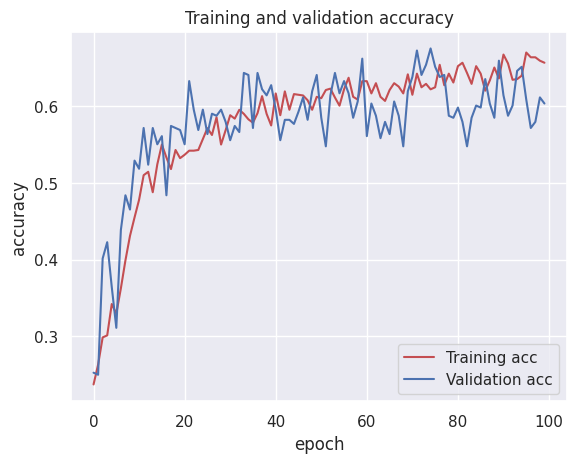

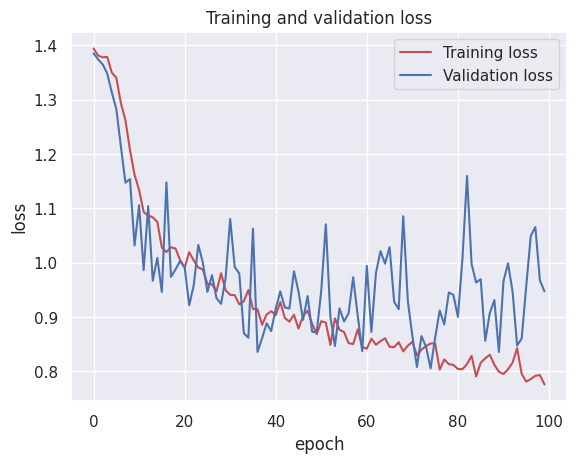

In [ ]:
#Graphing our training and validation
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
#model.save("simple_animal_classification_model.h5")#save model

In [ ]:
#from keras.models import load_model
#model=load_model("simple_animal_classification_model.h5")

## Task 7: Testing

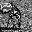

In [ ]:
from keras.preprocessing import image
test_image = image.load_img("../input/african-wildlife/zebra/001.jpg",target_size=(32,32),color_mode='grayscale')
test_image


In [ ]:
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)

In [ ]:
result = model.predict(test_image)

my_dict=training_set.class_indices
def get_key(val):
    for key, value in my_dict.items():
         if val == value:
             return key

    return "key doesn't exist"

pred=list(result[0])
for i in range(len(pred)):
    if pred[i]!=0:
        print(get_key(i))

1/1 [==============================] - 0s 211ms/step
zebra
